In [55]:
#Importing Required Libraries
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

#Declaring the Hyperparameters

N = 10
T = 7
R = 0.8
M = 5
F = 0.0005   # 0.5% Brokerage fee

In [56]:
def GetData(NameOfFile):
  #START CODE HERE
  cols = ['tic', 'datadate', 'adjcp']

  data = pd.read_csv(NameOfFile, usecols=cols)
  return data
    # pd.DataFrame Object

In [57]:
def PartitionData(Data):

  DateToIndex = {}
  PartitionedData = []

  unique_dates = Data['datadate'].unique()

  for idx, date in enumerate(unique_dates):
      # Filter the data for the current date
      date_data = Data[Data['datadate'] == date]

      PartitionedData.append(date_data)
      type(date)
      DateToIndex[date] = idx

  return PartitionedData, DateToIndex

In [58]:
def GetMomentumBasedPriority(PartitionedDataFrameList, DateToIndex ,today,data):
  # PartitionedDataFrameList : Pandas DataFrame, The Output of your last function
  # DateToIndex : Dictionary mapping dates to their index in the PartitionedDataFrameList
  # today :  Today's date (string) In Format: YYYYMMDD


  #NdaysAgo is a datatime.date() object contining the required data, you need to convert it to a string and then check if its
  #actually there in the Data you have or will you have to get going using some other nearest date
  indexT = DateToIndex[today]
  dfT = PartitionedDataFrameList[indexT]
  NdaysAgo = datetime.date(int(str(today)[0:4]), int(str(today)[4:6]), int(str(today)[6:])) + datetime.timedelta(days = -N)

  NdaysAgoInt = int(NdaysAgo.strftime('%Y%m%d'))

  boo=True
  while boo:
   if NdaysAgoInt in DateToIndex:
     index = DateToIndex[NdaysAgoInt]
     dfN=PartitionedDataFrameList[index]
     boo = False

   else:
     NdaysAgo = NdaysAgo + datetime.timedelta(days=-1)
     NdaysAgoInt = int(NdaysAgo.strftime('%Y%m%d'))

  dtype = np.dtype([('tic', 'U10'), ('adjcpT', float), ('adjcpN', float), ('momentum', float)])
  result = np.zeros((30,), dtype=dtype)

  result['tic'] = dfT['tic']
  result['adjcpT'] =  dfT['adjcp']
  result['adjcpN'] =  dfN['adjcp']
  result['momentum'] = result['adjcpT'] - result['adjcpN']


  #divide moemntum by man price
  Utic = data['tic'].unique()

  for ticker in Utic:

    # makes a datframe of each ticker along with their prices
    df_ticker = data[data['tic'] == ticker]
    df_ticker.reset_index(drop=True, inplace=True)

    # takes out the index of today's and N days ago's date
    idxT=df_ticker.index[df_ticker['datadate'] == today]
    idxN=df_ticker.index[df_ticker['datadate'] == NdaysAgoInt]

    # makes a dataframe of price between N days ago and today
    selected_rows = df_ticker.loc[idxN[0]:idxT[0]]
    mean_values = selected_rows['adjcp'].mean()


    index = np.where(result['tic'] == ticker)
    result['momentum'][index] = result['momentum'][index] / mean_values

  result_sorted = np.sort(result, order='momentum')[::-1]

  return result_sorted


In [59]:
# GetBalanced (this fucntion is made in next cell)

In [60]:


class PortFolio:
    def __init__(self, Ibal, Cbal, Cstocks, prices):
        self.Ibal = Ibal
        self.Cbal = Cbal
        data = [["AAPL", 0], ["AXP", 0], ["BA", 0], ["CAT", 0], ["CSCO", 0], ["CVX", 0], ["DD", 0], ["DIS", 0], ["GS", 0], ["HD", 0], ["IBM", 0], ["INTC", 0], ["JNJ", 0], ["JPM", 0], ["KO", 0], ["MCD", 0], ["MMM", 0], ["MRK", 0], ["MSFT", 0], ["NKE", 0], ["PFE", 0], ["PG", 0], ["RTX", 0], ["TRV", 0], ["UNH", 0], ["V", 0], ["VZ", 0], ["WBA", 0], ["WMT", 0], ["XOM", 0]]
        self.Cstocks = np.array(data, dtype=object)
        self.prices = np.array(data, dtype=object)


    def SellStock(self, index):
        money = self.prices[index,1] * self.Cstocks[index,1] * (1 - F)
        self.Cbal += money
        self.Cstocks[index,1] = 0

    def BuyStock(self, index, number):
        money = self.prices[index,1] * number * (1 + F)
        self.Cbal -= money
        self.Cstocks[index,1] += number

    def CalculateNetWorth(self):
        return np.dot(self.prices[:, 1], self.Cstocks[:, 1]) + self.Cbal

    def ChangePricesTo(self, newPriceVector):
        self.prices[:,1] = newPriceVector

    def RebalancePortFolio(self, newWeights):

        def GetBalanced(prices, weights,balance):
          weight=weights['momentum']
          normalized_weights = weight / np.sum(weight)
          allocated_balance = normalized_weights * balance

          number_of_shares = np.zeros(M)

          for i in range(M):
            tic = newWeights['tic'][i]
            k = np.where(self.prices[:, 0] == tic)[0]
            number_of_shares[i] = allocated_balance[i] / self.prices[k,1]

          number_of_shares = np.floor(number_of_shares)
          return number_of_shares

        for i in range(30):
            if self.Cstocks[i,1] > 0:
                self.SellStock(i)

        shares_to_buy = GetBalanced(self.prices, newWeights, self.Cbal)

        for i in range(M):
            tic = newWeights['tic'][i]
            k = np.where(self.prices[:, 0] == tic)[0]
            if shares_to_buy[i] > 0:
                self.BuyStock( k , shares_to_buy[i])


In [61]:
Ibal=10000
Cbal=Ibal
data = [["AAPL", 0], ["AXP", 0], ["BA", 0], ["CAT", 0], ["CSCO", 0], ["CVX", 0], ["DD", 0], ["DIS", 0], ["GS", 0], ["HD", 0], ["IBM", 0], ["INTC", 0], ["JNJ", 0], ["JPM", 0], ["KO", 0], ["MCD", 0], ["MMM", 0], ["MRK", 0], ["MSFT", 0], ["NKE", 0], ["PFE", 0], ["PG", 0], ["RTX", 0], ["TRV", 0], ["UNH", 0], ["V", 0], ["VZ", 0], ["WBA", 0], ["WMT", 0], ["XOM", 0]]
Cstocks = np.array(data, dtype=object)
prices = np.array(data, dtype=object)

myPortfolio = PortFolio(Ibal,Cbal,Cstocks,prices)
NetWorthAfterEachTrade = []


#First Get the Data
Data = GetData('/content/DATA.csv')
PartitionedData, DateToIndex= PartitionData(Data)



#Start processing from the (N+1)th Day(among the ones recorded in the Data)
for i in range(N, len(DateToIndex)):

# Change the Prices to the ith Term

  df = PartitionedData[i]
  today = df['datadate'].iloc[0]
  prices = df['adjcp'].to_numpy()
  myPortfolio.ChangePricesTo(prices)

# Get NetWorth and store in list
  net_worth = myPortfolio.CalculateNetWorth()
  net_worth_int = int(net_worth)
  NetWorthAfterEachTrade.append(net_worth_int)

# Check if you need to rebalance Portfolio's Today
  if i % T == 0:

    # If so, do it by Calling first the GetMomentumBasedPriority function and then passing it to the rebalance function
    top_indices = np.arange(min(M, 30))
    weights = GetMomentumBasedPriority(PartitionedData, DateToIndex, today,Data)
    myPortfolio.RebalancePortFolio(weights[top_indices])


<ipython-input-60-6137e6e9dc66>:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  number_of_shares[i] = allocated_balance[i] / self.prices[k,1]
<ipython-input-61-a5a0a46ea5e4>:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  net_worth_int = int(net_worth)


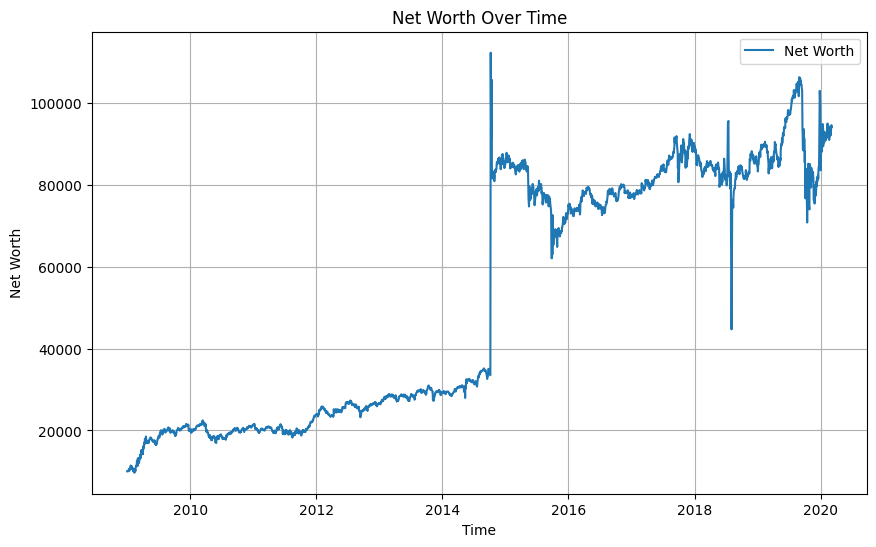

In [62]:
def VisualizeData(NetWorthAfterEachTrade):
    plt.figure(figsize=(10, 6))
    dates = pd.date_range(start='2009-01-01', periods=len(NetWorthAfterEachTrade), freq='B')
    plt.plot(dates, NetWorthAfterEachTrade, label='Net Worth')
    plt.title('Net Worth Over Time')
    plt.xlabel('Time')
    plt.ylabel('Net Worth')
    plt.legend()
    plt.grid(True)
    plt.show()



VisualizeData(NetWorthAfterEachTrade)

You may use this cell to write about what results you got!